# Быстрая классификация твитов с помощью CatBoost. Описание проекта.

Ссылка на Kaggle: https://www.kaggle.com/datasets/aunanya875/suicidal-tweet-detection-dataset

Рассматриваемый датасет содержит твиты пользователей, часть из которых можно охарактеризовать как относящиеся к теме суицида, а часть нет. Правильная и оперативная классификация сообщений может помочь как во время оказать нуждающемуся психологическую помощь, так и защитить детей от от вредоносной информации, распространяемой злоумышленниками.

За этот проект я взялся для оценки возможностей CatBoost работать с текстом. Качество моделей будет оцениваться с помощью метрики F1.


# Загрузка данных.

Загружаем необходимые библоитеки.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.feature_extraction.text import (
    TfidfVectorizer,
    CountVectorizer,
    TfidfTransformer,
)
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
import re

!pip install catboost
from catboost import CatBoostClassifier, Pool, cv

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.9 MB/s eta 0:00:00


Фиксируем значение для Random State.

In [2]:
RND_STATE = 42

Загружаем данные.

In [3]:
df = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/Datasets/Suicide_Ideation_Dataset(Twitter-based).csv",
    sep=",",
)

Смотрим информацию о них.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1787 entries, 0 to 1786
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Tweet    1785 non-null   object
 1   Suicide  1787 non-null   object
dtypes: object(2)
memory usage: 28.0+ KB


In [5]:
df.sample(10)

,Tweet,Suicide
1013,@nomadicmatt i'd like to be linked on your sit...,Not Suicide post
802,At the end of the day Iâm at this point in m...,Potential Suicide post
1261,"@joniconix Ah, you refer to the tabloid not le...",Not Suicide post
1769,"@jhaebets Nah, AUS PC is more salesy (best lef...",Not Suicide post
1254,RT @PrincessSGB: I'm pleased to announce that ...,Not Suicide post
1217,I will have a stan chart card not because i wa...,Not Suicide post
1220,â¡sigh i hate this i hardly get time to mysel...,Potential Suicide post
1493,@janniesTWbox But the dip keeps following me! ...,Not Suicide post
624,Havenât watched WWE since Extreme Rules. I w...,Potential Suicide post
1248,Busy times at Elstree Studios. New arrivals in...,Not Suicide post


Смотрим пропуски в столбце с твитами.

In [6]:
rows_with_missing_tweet = df[df['Tweet'].isnull()]
rows_with_missing_tweet

,Tweet,Suicide
497,NaN,Potential Suicide post
1017,NaN,Not Suicide post


Удаляем их.

In [7]:
df = df.dropna(subset=['Tweet'])

Смотрим распределение целевого признака.

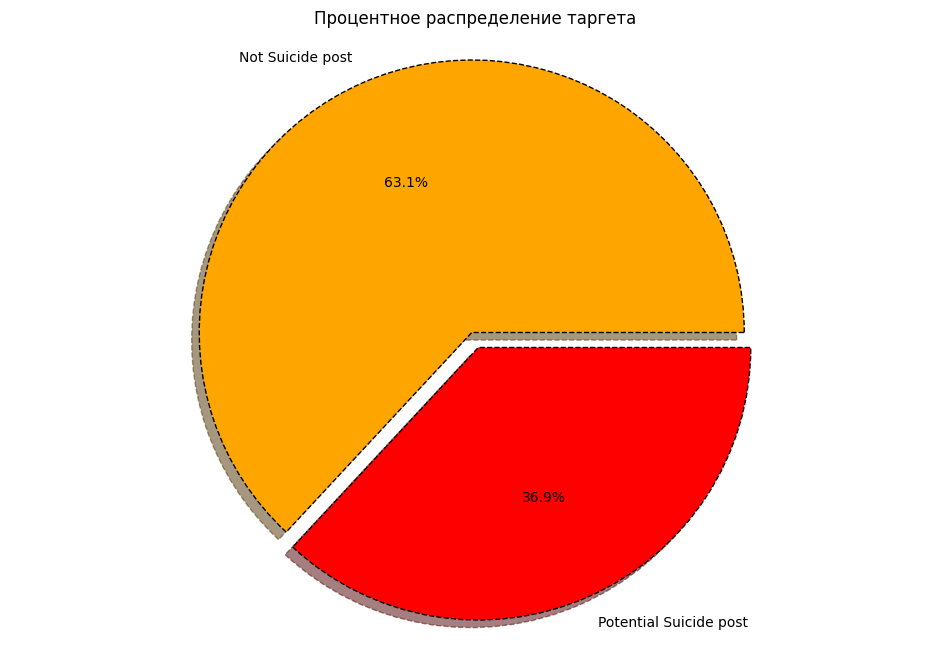

In [8]:
counts = df['Suicide'].value_counts()

explode = [0.05, 0.01] + [0] * (len(counts) - 3)
plt.figure(figsize=(12, 8))
plt.pie(
  counts.values,
  labels=counts.index,
  autopct='%1.1f%%',
  shadow=True,
  explode=explode,
  colors=['orange', 'red'] + ['C0'] * (len(counts) - 3),
  wedgeprops={'lw': 1, 'ls': '--', 'edgecolor': 'k'},
)
plt.axis('equal')
plt.title('Процентное распределение таргета')
plt.show()

В данных есть перекос в сторону "несуицидальных" твитов, которое надо будет учесть.

Закодируем целевой признак цифрами 0 и 1.

In [9]:
df["Suicide"] = df["Suicide"].map({"Not Suicide post": 0, "Potential Suicide post ": 1})

## Выводы по разделу.

- Требуемые библиотеки и данные загружены.
- Информация о данных просмотрена.
- Строки с пропуска удалены.
- Обнаружен дисбаланс целевого класса.

# Тренировочная выборка.

Обучим на тренировочных данных и оценим при помощи кросс-валидации CatBoost дважды: первый раз в модель придут сырые данные, во второй же мы вручную очистим тексты и векторизуем их. Результаты качества моделей сравним, и на тестовых данных предсказание будет делать уже лучшая из них.

## CatBoost без предобработки текстовых данных.

Разделим данные на тренировочную и тестовую выборки.

In [10]:
target = df["Suicide"]
features = df.drop(["Suicide"], axis=1)

features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size=0.2,
    random_state=RND_STATE,
    stratify=target,
    shuffle=True,
)

Смотрим размеры выборок.

In [11]:
features_train.shape, target_train.shape, features_test.shape, target_test.shape

((1428, 1), (1428,), (357, 1), (357,))

Создаём объект класса Pool для обучения на неём CatBoost.

In [12]:
pool_train = Pool(
    data=features_train,
    label=target_train,
    text_features=[0],
    feature_names=['Tweet']
)

Обучаем CatBoost на тренировочной выборке с применением кросс-валдидации, получаем значение метрики.

In [13]:
model = CatBoostClassifier(
    auto_class_weights="Balanced", random_seed=RND_STATE, task_type="GPU"
)

params = {
    "iterations": 100,
    "learning_rate": 0.1,
    "depth": 6,
    "loss_function": "Logloss",
    "verbose": False,
    "custom_loss": "F1",
    "metric_period": 1,
}

cv_data = cv(pool_train, params=params, fold_count=5)

f1_train = cv_data["test-F1-mean"].mean()

print("Среднее значение метрики F1 на кросс-валидации:", f1_train)

Training on fold [0/5]

bestTest = 0.2752864458
bestIteration = 98

Training on fold [1/5]

bestTest = 0.3069929559
bestIteration = 95

Training on fold [2/5]

bestTest = 0.3574634045
bestIteration = 99

Training on fold [3/5]

bestTest = 0.2657273301
bestIteration = 96

Training on fold [4/5]

bestTest = 0.2827087403
bestIteration = 99

Среднее значение метрики F1 на кросс-валидации: 0.8113356039564207


Значение метрики выглядит уже неплохо, но посмотрим, что будет, если мы выполним в ручную предобработку текстовых данных до того, как отправлять их в модель.

## CatBoost с предобработкой текстовых данных.

Создаём корпус постов.

In [14]:
corpus = df['Tweet']

Создаём функции для лемматизации и очистки текстов.

In [15]:
def clear_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = text.split()
    text = " ".join(text)
    return text


def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        "J": wordnet.ADJ,
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "R": wordnet.ADV,
    }
    return tag_dict.get(tag, wordnet.NOUN)


def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmatized_tokens = [
        lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens
    ]
    lemmatized_text = " ".join(lemmatized_tokens)
    return lemmatized_text

Применяем функции на корпусе.

In [16]:
tqdm.pandas()
corpus = corpus.progress_apply(clear_text)
corpus = corpus.progress_apply(lemmatize_text)

100%|██████████| 1785/1785 [00:06<00:00, 283.49it/s]


Присоединяем очищенные тексты к датафрейму.

In [17]:
df['Cleared Tweet'] = corpus

Смотрим, что получилось.

In [18]:
df.sample(10)

,Tweet,Suicide,Cleared Tweet
379,"@o_crunk Keep it up, you do good work!",0,o crunk keep it up you do good work
1724,@DerrenLitten What is the software on the midd...,0,derrenlitten what be the software on the middl...
1610,Working like crazy,0,work like crazy
260,I wanna kill myself like not literally but men...,1,i wan na kill myself like not literally but me...
725,is off to Dundrum with Martin,0,be off to dundrum with martin
64,@noi27 Easy way is to go to MBK and get it hac...,0,noi easy way be to go to mbk and get it hack c...
775,my life has no purpose i am broke lonely and m...,1,my life have no purpose i be broke lonely and ...
1430,LOLOLOLOLOL I HATE HOW I TRUST PEOPLE WITH UGL...,1,lololololol i hate how i trust people with ugl...
1579,RT @WayneRooney: Congratulations to Joe Cole o...,0,rt waynerooney congratulation to joe cole on a...
650,"@healthwarrior A watched pot never boiled, mat...",0,healthwarrior a watch pot never boil mate dist...


In [19]:
target = df["Suicide"]
features = df["Cleared Tweet"]
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size=0.2,
    random_state=RND_STATE,
    stratify=target,
    shuffle=True,
)

Выполянем векторизацию текстов.

In [20]:
stop_words = set(stopwords.words('english'))

tfidf_vectorizer = TfidfVectorizer(stop_words='english')

features_train_tfidf = tfidf_vectorizer.fit_transform(features_train)

features_test_tfidf = tfidf_vectorizer.transform(features_test)

Смотрим размеры выборок.

In [21]:
print(f'Размер тренировочной выборки: {features_train_tfidf.shape}')
print(f'Размер тестовой выборки: {features_test_tfidf.shape}')

Размер тренировочной выборки: (1428, 4549)
Размер тестовой выборки: (357, 4549)


Создаём объекты Pool.

In [22]:
pool_train_tfidf = Pool(
    data=features_train_tfidf,
    label=target_train)

pool_test_tfidf = Pool(
    data=features_test_tfidf,
    label=target_test)

In [23]:
model = CatBoostClassifier(
    auto_class_weights='Balanced',
    random_seed=RND_STATE,
    task_type="GPU"
)


params = {
    'iterations': 100,
    'learning_rate': 0.1,
    'depth': 6,
    'loss_function': 'Logloss',
    'verbose': False,
    'custom_loss': 'F1',
    'metric_period': 1
}

cv_data_pre = cv(pool_train_tfidf, params=params, fold_count=5)

f1_train_pre =  cv_data_pre['test-F1-mean'].mean()

print('Среднее значение метрики F1 на тесте:', f1_train_pre)

Training on fold [0/5]

bestTest = 0.2266579135
bestIteration = 99

Training on fold [1/5]

bestTest = 0.2451896575
bestIteration = 95

Training on fold [2/5]

bestTest = 0.2447973146
bestIteration = 99

Training on fold [3/5]

bestTest = 0.2432216857
bestIteration = 99

Training on fold [4/5]

bestTest = 0.2187381733
bestIteration = 98

Среднее значение метрики F1 на тесте: 0.8507181651537734


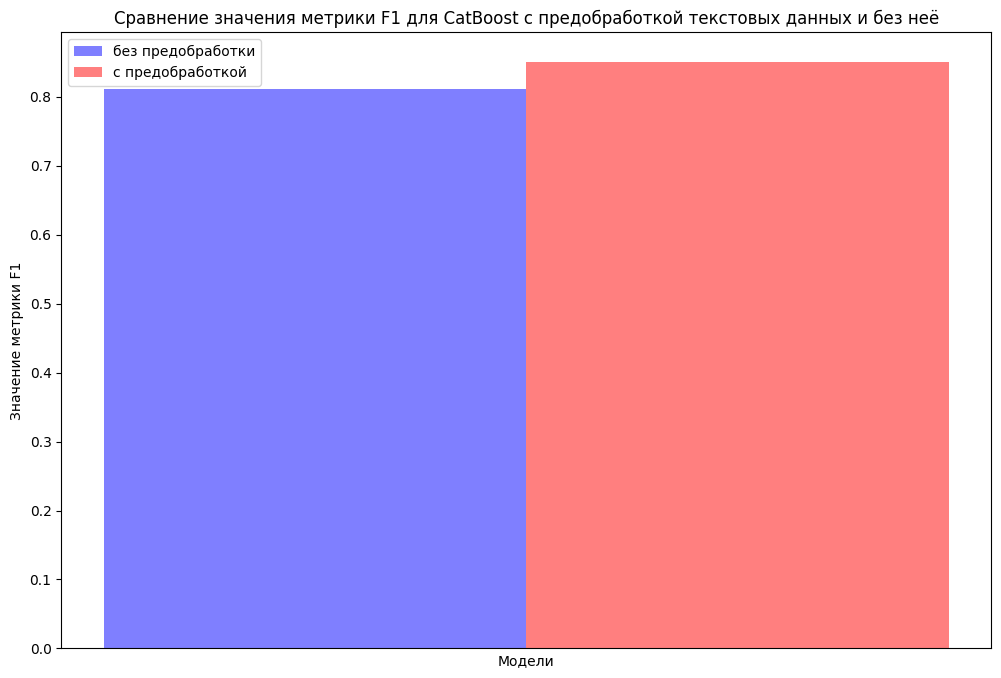

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.35

rects1 = ax.bar(
    1, f1_train, bar_width, label="без предобработки", color="b", alpha=0.5
)
rects2 = ax.bar(
    1 + bar_width,
    f1_train_pre,
    bar_width,
    label="c предобработкой", color="r", alpha=0.5
)

ax.set_xticks([])

ax.set_xlabel("Модели")
ax.set_ylabel("Значение метрики F1")
ax.set_title(
    "Сравнение значения метрики F1 для CatBoost с предобработкой текстовых данных и без неё"
)
ax.set_xticks([])
ax.legend()

plt.show()


Ручная предобработка текстовых данных помогла увеличить значение метрики.

## Выводы по разделу.
- CatBoost на сырых текстовых данных дал значение метрики F1 0.81, на предобработанных - 0.85.
- Предсказание модели будем получать также на предобработанных данных.

# Тестовая выборка.

Обучаем модель на тренировочной выборке, получаем предсказание на тестовой.

In [25]:
model.fit(features_train_tfidf, target_train, verbose=0)
predictions = model.predict(features_test_tfidf)

Считаем значение метрики.

In [26]:
f1_test = f1_score(target_test, predictions)
f1_test

0.873134328358209

Метрика немного подросла по сравнению с тренировочной выборкой.

Смотрим матрицу ошибок.

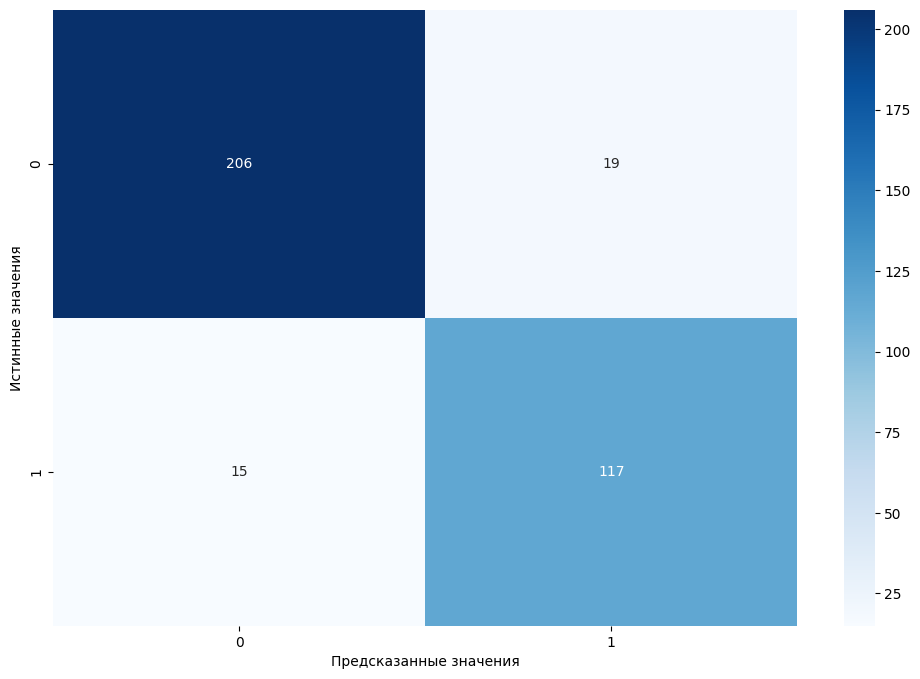

In [27]:
cm = confusion_matrix(target_test, predictions)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True,  fmt='d', cmap='Blues')
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')

plt.show()

## Выводы по разделу.
- Предсказание модели на тестовой выборке получено.
- Значение метрики F1 0.87.
- Моделью верно распознаны 117 из 132 (88%) "суицидальных" твитов 206 из 215 (91%) "несуицидальных".

# Выводы по проекту.

По итогу проекта могу сказать, что даже при быстрой классификации на сырых данных с помощью text_features модель CatBoost обеспечила адекватное значение метрики, которое можно использовать в качестве бейзлайна при попытки достижения максимально точной классификации. Очистка и векторизация текстов перед отправлением их в модель помогли увеличить значение метрики, однако в случае решения вопроса на реальных данных целесообразным будет попытка применения нейросетей, которые в теории должны ещё больше повысить точность классификации в данном вопросе.